# 0. Imports 

In [1]:
import matplotlib
import optuna

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn import tree
from xgboost import XGBClassifier
from optuna import Trial

from imblearn import over_sampling as oversamp
from imblearn import under_sampling as undersamp
from imblearn import combine as comb

# 1. Loading Data 

In [2]:
df1_client_train = pd.read_csv('dataset/client_train.csv', low_memory=False)
df1_invoice_train = pd.read_csv('dataset/invoice_train.csv', low_memory=False)

# 2. Data Description 

In [3]:
df2_client_train = df1_client_train.copy()
df2_invoice_train = df1_invoice_train.copy()

## 2.0 Data Dimensions 

In [4]:
print(f'df2_client_train (lines = {df2_client_train.shape[0]}, cols = {df2_client_train.shape[1]})')
print(f'df2_invoice_train (lines = {df2_invoice_train.shape[0]}, cols = {df2_invoice_train.shape[1]})')

df2_client_train (lines = 135493, cols = 6)
df2_invoice_train (lines = 4476749, cols = 16)


## 2.1 Data Types 

In [5]:
print('-----------------------------------')
print('df2_client_train')
print('-----------------------------------')
print(df2_client_train.dtypes)
print('-----------------------------------')
print('df2_invoice_train')
print('-----------------------------------')
print(df2_invoice_train.dtypes)

-----------------------------------
df2_client_train
-----------------------------------
disrict            int64
client_id         object
client_catg        int64
region             int64
creation_date     object
target           float64
dtype: object
-----------------------------------
df2_invoice_train
-----------------------------------
client_id               object
invoice_date            object
tarif_type               int64
counter_number           int64
counter_statue          object
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type            object
dtype: object


## 2.2 Checking Na 

In [6]:
print('-----------------------------------')
print('df2_client_train')
print('-----------------------------------')
print(df2_client_train.isna().sum())
print('-----------------------------------')
print('df2_invoice_train')
print('-----------------------------------')
print(df2_invoice_train.isna().sum())


-----------------------------------
df2_client_train
-----------------------------------
disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64
-----------------------------------
df2_invoice_train
-----------------------------------
client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64


## 2.3 Data Overview 

### 2.3.1 Clients 

In [7]:
df2_client_train.columns.tolist()

['disrict', 'client_id', 'client_catg', 'region', 'creation_date', 'target']

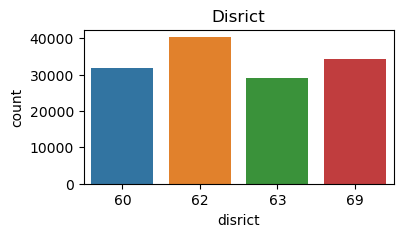

In [8]:
plt.figure(figsize=(4,2));
sns.countplot(data=df2_client_train, x='disrict');
plt.title('Disrict'); # provavelmente distrito

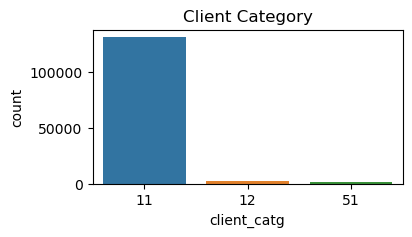

In [9]:
plt.figure(figsize=(4,2));
sns.countplot(data=df2_client_train, x='client_catg');
plt.title('Client Category');

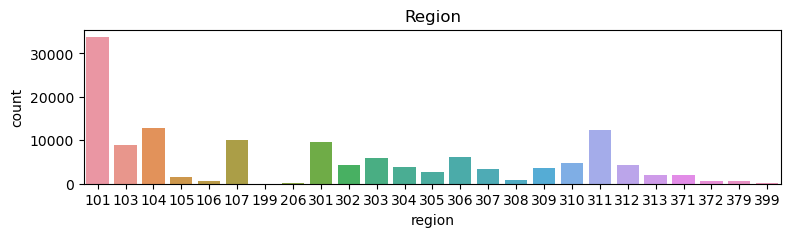

In [10]:
plt.figure(figsize=(9,2));
sns.countplot(data=df2_client_train, x='region');
plt.title('Region');

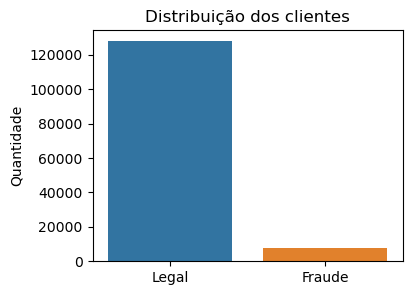

In [11]:
plt.figure(figsize=(4,3));
sns.countplot(data=df2_client_train, x='target',)
plt.title('Distribuição dos clientes');
plt.ylabel('Quantidade');
plt.xlabel('');
plt.xticks(ticks=[0,1], labels=['Legal', 'Fraude']);

In [12]:
df2_client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


### 2.3.2 Invoices 

In [13]:
df2_invoice_train.columns.tolist()

['client_id',
 'invoice_date',
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'counter_coefficient',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type']

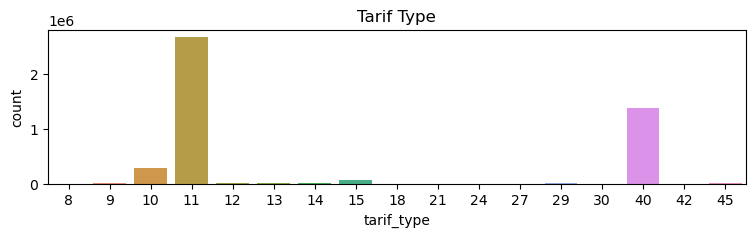

In [14]:
plt.figure(figsize=(9,2))
sns.countplot(data=df2_invoice_train, x='tarif_type');
plt.title('Tarif Type');

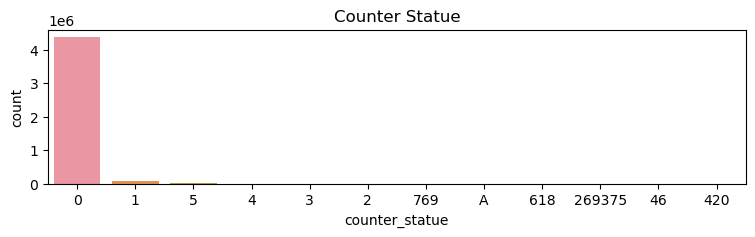

In [15]:
plt.figure(figsize=(9,2))
sns.countplot(data=df2_invoice_train, x='counter_statue');
plt.title('Counter Statue');

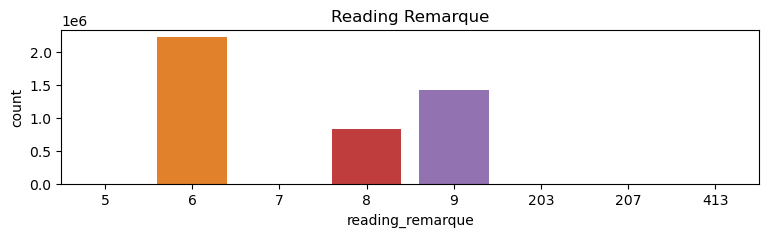

In [16]:
plt.figure(figsize=(9,2));
sns.countplot(data=df2_invoice_train, x='reading_remarque');
plt.title('Reading Remarque');

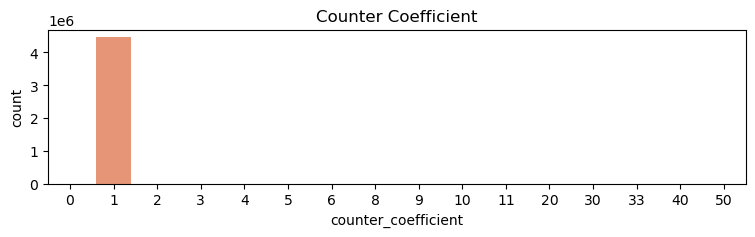

In [17]:
plt.figure(figsize=(9,2));
sns.countplot(data=df2_invoice_train, x='counter_coefficient');
plt.title('Counter Coefficient');

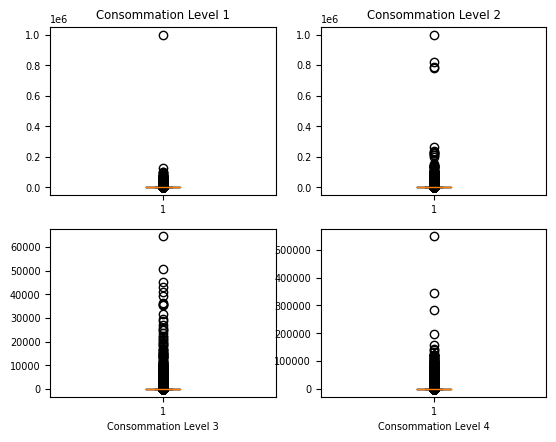

In [18]:
font = {'weight': 'normal', 'size': 7}

matplotlib.rc('font', **font)

plt.subplot(2,2,1);
plt.boxplot(df2_invoice_train.consommation_level_1);
plt.title('Consommation Level 1');

plt.subplot(2,2,2);
plt.boxplot(df2_invoice_train.consommation_level_2);
plt.title('Consommation Level 2');

plt.subplot(2,2,3);
plt.boxplot(df2_invoice_train.consommation_level_3);
plt.xlabel('Consommation Level 3');

plt.subplot(2,2,4);
plt.boxplot(df2_invoice_train.consommation_level_4);
plt.xlabel('Consommation Level 4');

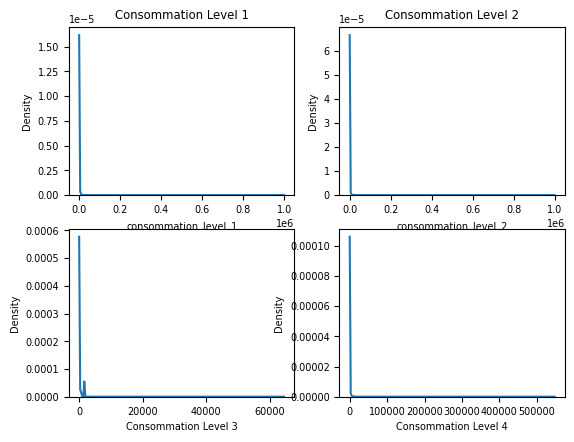

In [19]:
matplotlib.rc('font', **font)

plt.subplot(2,2,1);
sns.kdeplot(x=df2_invoice_train.consommation_level_1);
plt.title('Consommation Level 1');

plt.subplot(2,2,2);
sns.kdeplot(x=df2_invoice_train.consommation_level_2);
plt.title('Consommation Level 2');

plt.subplot(2,2,3);
sns.kdeplot(x=df2_invoice_train.consommation_level_3);
plt.xlabel('Consommation Level 3');

plt.subplot(2,2,4);
sns.kdeplot(x=df2_invoice_train.consommation_level_4);
plt.xlabel('Consommation Level 4');

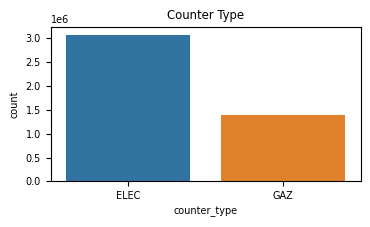

In [20]:
plt.figure(figsize=(4,2));
sns.countplot(data=df2_invoice_train, x='counter_type');
plt.title('Counter Type');

In [21]:
df2_client_train.target.value_counts(normalize=True)

0.0    0.944159
1.0    0.055841
Name: target, dtype: float64

In [22]:
df2_invoice_train.counter_type.value_counts(normalize=True)

ELEC    0.687867
GAZ     0.312133
Name: counter_type, dtype: float64

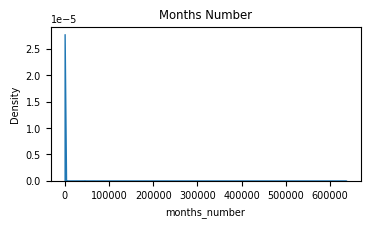

In [23]:
plt.figure(figsize=(4,2));
sns.kdeplot(data=df2_invoice_train, x='months_number', shade=True);
plt.title('Months Number');

In [24]:
df2_invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


## 2.4 Conclusions 

- Alterar o tipo de dado dos atributos 'creation_date' do dataframe de clientes, e os atributos 'reading_remarque',  'invoice_date' e 'counter_type' do dataframe invoices;
- Não existem dados ausentes;
- Como esperado, o target para fraudes é bastante subrepresentado (desbalanceamento);
- 'counter_statue', 'counter_remarquee' e e 'counter_coefficient' precisam ser tratados, pois tem ums distribuição de valores inadequada;
- Existem muito mais invoices de eletricidade que gás no dataset;
- 'consommation_level_x' tem distribuição com bastante outliers, indicando uma variabilidade alta nos consumos;


# 3. Feature Engineering

In [25]:
df3_client_train = df2_client_train.copy()
df3_invoice_train = df2_invoice_train.copy()

## 3.1 Changing Types

### 3.1.1 Client 

In [26]:
df3_client_train.dtypes

disrict            int64
client_id         object
client_catg        int64
region             int64
creation_date     object
target           float64
dtype: object

In [27]:
df3_client_train['creation_date'] = pd.to_datetime(df3_client_train.creation_date, infer_datetime_format=True)
#df3_client_train['disrict'] = df3_client_train.disrict.astype('category')
#df3_client_train['client_catg'] = df3_client_train.client_catg.astype('category')
#df3_client_train['region'] = df3_client_train.region.astype('category')
df3_client_train['target'] = df3_client_train.target.astype('int64')

In [28]:
df3_client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,1994-12-31,0
1,69,train_Client_1,11,107,2002-05-29,0
2,62,train_Client_10,11,301,1986-03-13,0
3,69,train_Client_100,11,105,1996-07-11,0
4,62,train_Client_1000,11,303,2014-10-14,0


### 3.1.2 Invoice 

In [29]:
df3_invoice_train.dtypes

client_id               object
invoice_date            object
tarif_type               int64
counter_number           int64
counter_statue          object
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type            object
dtype: object

In [30]:
df3_invoice_train['invoice_date'] = pd.to_datetime(df3_invoice_train.invoice_date, infer_datetime_format=True)
df3_invoice_train['tarif_type'] = df3_invoice_train.tarif_type.astype('category')
df3_invoice_train['counter_statue'] = df3_invoice_train.counter_statue.astype('category')
df3_invoice_train['reading_remarque'] = df3_invoice_train.reading_remarque.astype('category')
df3_invoice_train['counter_type'] = df3_invoice_train.counter_type.astype('category')
df3_invoice_train['counter_type'] = df3_invoice_train.counter_type.map({'ELEC': 1, 'GAZ': 0})

In [31]:
df3_invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,1
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,1
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,1
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,1
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,1


## 3.2 Features Creation and Manipulation

### 3.2.1 Client 

In [32]:
# ano, mes e idade
df3_client_train['year_creation'] = df3_client_train.creation_date.dt.year
df3_client_train['month_creation'] = df3_client_train.creation_date.dt.month
df3_client_train['age'] = (2020 - df3_client_train.year_creation) * 12 - df3_client_train.month_creation

In [33]:
df3_client_train.insert(len(df3_client_train.columns)-1, 'target', df3_client_train.pop('target'))
df3_client_train.head()

,disrict,client_id,client_catg,region,creation_date,year_creation,month_creation,age,target
0,60,train_Client_0,11,101,1994-12-31,1994,12,300,0
1,69,train_Client_1,11,107,2002-05-29,2002,5,211,0
2,62,train_Client_10,11,301,1986-03-13,1986,3,405,0
3,69,train_Client_100,11,105,1996-07-11,1996,7,281,0
4,62,train_Client_1000,11,303,2014-10-14,2014,10,62,0


### 3.2.2 Invoice 

In [34]:
# consumo, ano, mes e intervelo entre leituras
df3_invoice_train['delta_index'] = df3_invoice_train.new_index - df3_invoice_train.old_index
df3_invoice_train['invoice_year'] = df3_invoice_train['invoice_date'].dt.year
df3_invoice_train['invoice_month'] = df3_invoice_train['invoice_date'].dt.month
df3_invoice_train['delta_dates'] = df3_invoice_train.sort_values(['client_id', 'invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)

In [35]:
# atributos estatisticos com base na serie historica
features_to_agg = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'months_number', 'delta_index', 'delta_dates']
stats_features = df3_invoice_train.groupby('client_id')[features_to_agg].agg(['mean','std','min','max'])
stats_features.columns = ['_'.join(col).strip() for col in stats_features.columns.values]

In [36]:
# traduzindo os itens de counter_statue para algo mais simples
df3_invoice_train['counter_statue'].unique().tolist()

['0', '1', '5', '4', '3', '2', '769', 'A', '618', '269375', '46', '420']

In [37]:
df3_invoice_train['counter_statue'] = df3_invoice_train.counter_statue.map({'0': 0, '1': 1, '5': 5, '4': 4, '3': 3, '2': 2, '769': 6, 'A': 7, '618': 8, '269375': 9, '46': 10, '420': 11})

## 3.5 Merging DataFrames

In [38]:
df3 = pd.merge(df3_client_train, stats_features, on='client_id', how='left')
df3.insert(len(df3.columns)-1, 'target', df3.pop('target'))
df3.head()

,disrict,client_id,client_catg,region,creation_date,year_creation,month_creation,age,consommation_level_1_mean,consommation_level_1_std,...,months_number_max,delta_index_mean,delta_index_std,delta_index_min,delta_index_max,delta_dates_mean,delta_dates_std,delta_dates_min,delta_dates_max,target
0,60,train_Client_0,11,101,1994-12-31,1994,12,300,352.400000,310.343472,...,12,362.971429,341.553930,38,1386,144.147059,87.601070,40.0,508.0,0
1,69,train_Client_1,11,107,2002-05-29,2002,5,211,557.540541,197.935960,...,8,557.540541,197.935960,190,1207,136.472222,92.492312,4.0,372.0,0
2,62,train_Client_10,11,301,1986-03-13,1986,3,405,798.611111,513.841374,...,12,836.500000,646.808386,188,3082,289.470588,250.701794,20.0,738.0,0
3,69,train_Client_100,11,105,1996-07-11,1996,7,281,1.200000,3.607011,...,6,1.200000,3.607011,0,15,140.210526,95.569974,4.0,442.0,0
4,62,train_Client_1000,11,303,2014-10-14,2014,10,62,663.714286,224.831365,...,4,922.642857,633.485669,124,2382,121.923077,80.057752,4.0,301.0,0


# 4. Exploratory Data Analysis 

In [39]:
df4 = df3.copy()

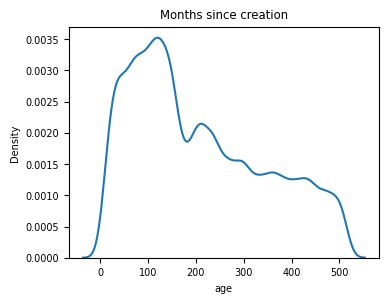

In [40]:
plt.figure(figsize=(4,3));
sns.kdeplot(data=df4, x='age');
plt.title('Months since creation');

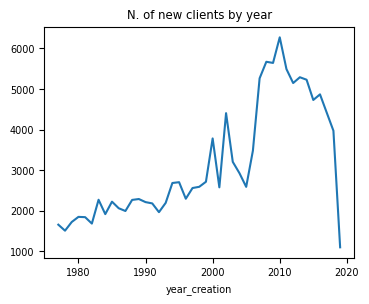

In [41]:
plt.figure(figsize=(4,3));
df4.groupby(by='year_creation').size().plot();
plt.title('N. of new clients by year');

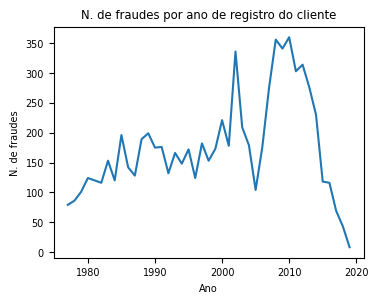

In [42]:
plt.figure(figsize=(4,3));
df4.groupby(by='year_creation').sum()['target'].plot();
plt.title('N. de fraudes por ano de registro do cliente');
plt.xlabel('Ano');
plt.ylabel('N. de fraudes');

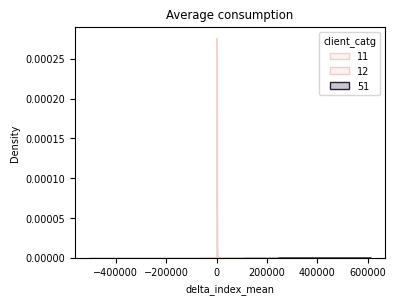

In [43]:
plt.figure(figsize=(4,3));
sns.kdeplot(data=df4, x='delta_index_mean', shade=True, hue='client_catg');
plt.title('Average consumption');

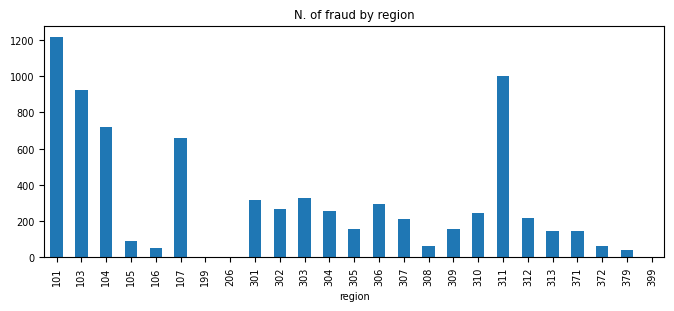

In [44]:
plt.figure(figsize=(8,3));
df4.groupby('region')['target'].sum().plot(kind='bar');
plt.title('N. of fraud by region');

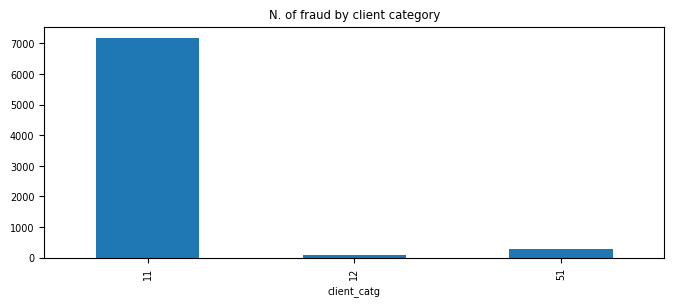

In [45]:
plt.figure(figsize=(8,3));
df4.groupby('client_catg')['target'].sum().plot(kind='bar');
plt.title('N. of fraud by client category');

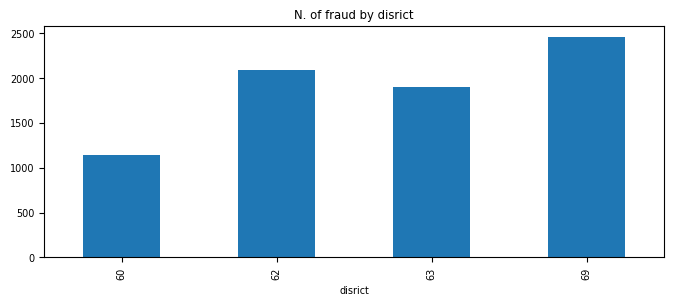

In [46]:
plt.figure(figsize=(8,3));
df4.groupby('disrict')['target'].sum().plot(kind='bar');
plt.title('N. of fraud by disrict');

## 4.1 Conclusions 

- A maioria dos clientes tem ~8 anos de relacionamento com a empresa;
- O número de clientes cresceu a uma taxa constante entre os anos 1980 e 1990, mas em 2005 houve um crescimento massivo;
- O número de fraudes registradas com relação ao ano de início do relacionamento com o cliente segue um padrão próximo ao do número de novos clientes da empresa, sendo os cliente novos entre 2005-2010 um grupo de fraudadores bastante intenso.
- A região mais fraudulenta é a 101;
- A categoria de cliente mais fraudulento é o 11;
- O distrito mais fraudulento é o 69.

# 5. Data Preparation 

In [170]:
df5 = df4.copy()

In [171]:
df5 = df5.drop(['client_id', 'creation_date'], axis=1).dropna()

In [172]:
X, y = df5.drop('target', axis=1), df5[['target']]

## 5.1 Split Data 

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## 5.2 Undersampling

In [176]:
undersampling = undersamp.RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_train, y_train = undersampling.fit_resample(X_train, y_train)

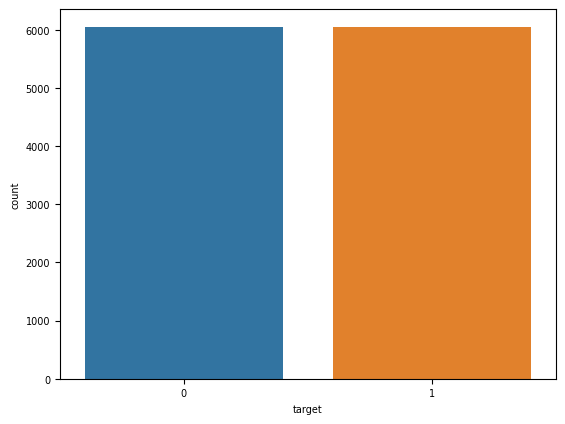

In [212]:
sns.countplot(data=y_train, x='target');

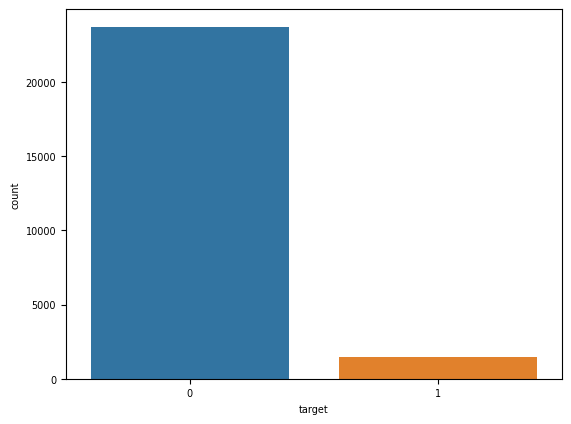

In [213]:
sns.countplot(data=y_test, x='target');

# 6. Machine Learning Modeling 

## 6.1 Decision Tree 

In [179]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [180]:
print(f'Accuracy score = {accuracy_score(y_test, y_pred_dt)}')
print(f'F1-Score = {f1_score(y_test, y_pred_dt)}')
print(f'ROC-AUC Score = {roc_auc_score(y_test, y_pred_dt)}')

Accuracy score = 0.6095623858311492
F1-Score = 0.15314384151593452
ROC-AUC Score = 0.6134269280405589


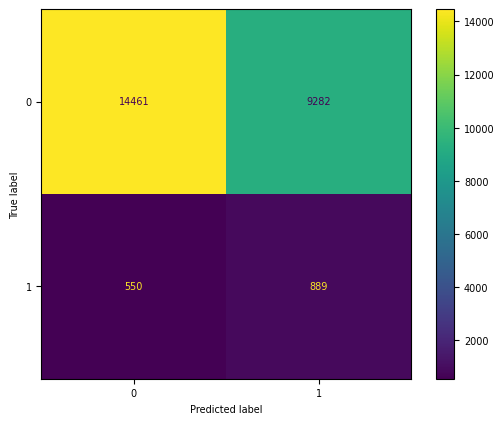

In [181]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt);

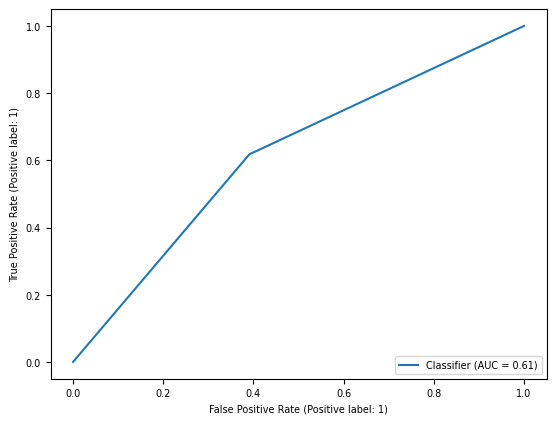

In [182]:
RocCurveDisplay.from_predictions(y_test, y_pred_dt);

## 7.2 LightGBM 

In [183]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train.values.ravel())
y_pred_lgbm = lgbm.predict(X_test)

In [184]:
print(f'Accuracy score = {accuracy_score(y_test, y_pred_lgbm)}')
print(f'F1-Score = {f1_score(y_test, y_pred_lgbm)}')
print(f'ROC-AUC Score = {roc_auc_score(y_test, y_pred_lgbm)}')

Accuracy score = 0.665912159478993
F1-Score = 0.19638933995606073
ROC-AUC Score = 0.688679669955465


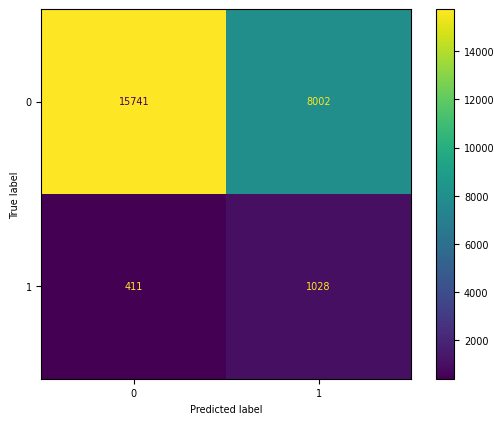

In [185]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm);

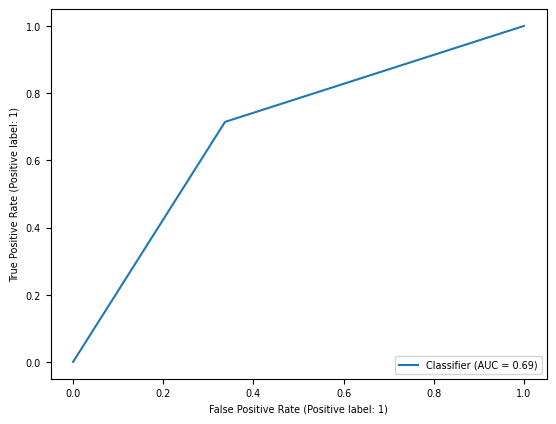

In [186]:
RocCurveDisplay.from_predictions(y_test, y_pred_lgbm);

## 7.3 XGBoost 

In [187]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [188]:
print(f'Accuracy score = {accuracy_score(y_test, y_pred_xgb)}')
print(f'F1-Score = {f1_score(y_test, y_pred_xgb)}')
print(f'ROC-AUC Score = {roc_auc_score(y_test, y_pred_xgb)}')

Accuracy score = 0.6476848542609801
F1-Score = 0.1821533923303835
ROC-AUC Score = 0.665957476014949


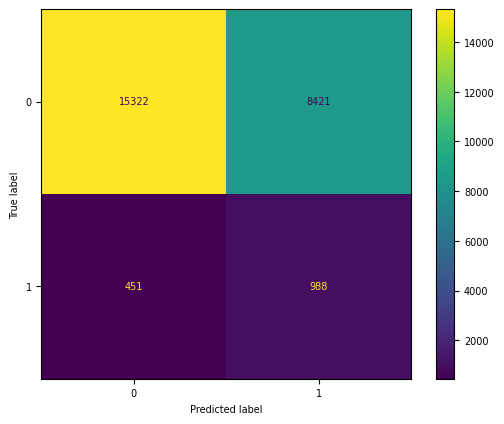

In [189]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb);

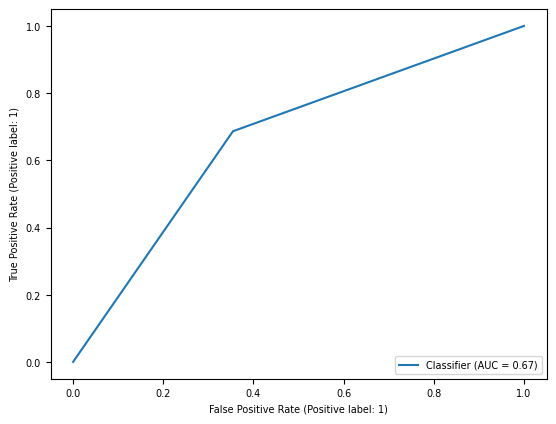

In [190]:
RocCurveDisplay.from_predictions(y_test, y_pred_xgb);

## 7.4 Summary Results 

In [191]:
results = {'Model': ['Decision Tree', 'LighGBM', 'XGBoost'],
           'Accuracy': [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_lgbm), accuracy_score(y_test, y_pred_xgb)],
           'F1-Score': [f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_lgbm), f1_score(y_test, y_pred_xgb)],
           'ROC-AUC Score': [roc_auc_score(y_test, y_pred_dt), roc_auc_score(y_test, y_pred_lgbm), roc_auc_score(y_test, y_pred_xgb)]}

pd.DataFrame(results).sort_values('ROC-AUC Score', ascending=False)

,Model,Accuracy,F1-Score,ROC-AUC Score
1,LighGBM,0.665912,0.196389,0.688680
2,XGBoost,0.647685,0.182153,0.665957
0,Decision Tree,0.609562,0.153144,0.613427


- Podemos ver que o melhor modelo foi o LightGBM nas três métricas avaliadas;
- Na próxima seção será feito o fine tuning do modelo;

# 8. Fine Tuning and Cross Validation

In [202]:
cv = StratifiedKFold(n_splits=5)
random_search = RandomizedSearchCV(lgb.LGBMClassifier(random_state=42), 
                             {
                                 'n_estimators': np.arange(100,1000, 50), 
                                 'num_leaves': 2**np.arange(5, 15, 1),
                                 'max_depth': 2**np.arange(2, 10, 1),
                                 'learning_rate': np.arange(0.01, 0.3, 0.005),
                                 'min_split_gain': np.arange(0.001, 0.50, 0.025),
                                 'feature_fraction': np.arange(0.01, 1.0, 0.05),
                                 'bagging_freq': np.arange(1, 10, 1),                                 
                             }, scoring=['f1', 'accuracy', 'recall','roc_auc'], refit='roc_auc',  n_iter=1000, cv=cv, n_jobs=-1)

results = random_search.fit(X_train, y_train.values.ravel())

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.46, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq 

/Users/mahelvson/opt/anaconda3/envs/gefraud/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.46, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq 

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.060000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.060000000000000005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fr

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8600000000000001
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.26, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.26, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[LightGBM] [Warning] bagging_freq is

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.41000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41000000000000003
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.46, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[Light

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01
[Light

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_freq is

[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.41000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41000000000000003
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.41000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41000000000000003
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.060000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.060000000000000005
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.060000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fracti

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.51, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] bagging_freq 

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.26, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000000000000002
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000000000000002
[Lig

[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] bagging_freq is set=2, subsample_

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.26, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.41000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41000000000000003
[LightGBM] [Warning] bagging_freq 

[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8600000000000001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.51, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.51, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51
[LightGBM] [Warning] bagging_freq 

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.11, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[Light

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.46, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000000000000002
[Lig

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.060000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.060000000000000005
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.060000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.060000000000000005
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be i

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.46, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000000000000002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000000000000002
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored.

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Cur

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] bagging_freq is

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.060000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fr

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.51, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.51, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51
[LightGBM] [Warning] bagging_freq 

[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8600000000000001
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.11, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[Light

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.26, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] bagging_freq is

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.060000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.060000000000000005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000000000000002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.41000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Cu

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000000000000002
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.26, colsample_bytree=1.0 will be ignored. Current value

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8600000000000001
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] bagging_freq is

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.46, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8600000000000001
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7100000000000001
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGB

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.51, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.31000000000000005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31000000000000005
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.66, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] bagging_freq 

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.81, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81
[Lig

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6100000000000001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.91, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fracti

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.16000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16000000000000003
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9600000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9600000000000001
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.46, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46
[Light

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000000000000002
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_frac

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.21000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21000000000000002
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.6100000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_frac

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.36000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36000000000000004
[LightGBM] [Warning] bagging_freq 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.26, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26


In [203]:
metrics = {
    'F1-Score': results.cv_results_['mean_test_f1'],
    'Accuracy': results.cv_results_['mean_test_accuracy'],
    'Recall':   results.cv_results_['mean_test_recall'],
    'AUC-ROC':  results.cv_results_['mean_test_roc_auc'],
}

pd.DataFrame(metrics).sort_values(by='AUC-ROC', ascending=False).head(1)

,F1-Score,Accuracy,Recall,AUC-ROC
211,0.701229,0.692435,0.722004,0.763865


In [204]:
pd.DataFrame(metrics).describe()

,F1-Score,Accuracy,Recall,AUC-ROC
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.679490,0.672576,0.694382,0.739958
std,0.011249,0.010507,0.014086,0.012690
min,0.626062,0.624463,0.628352,0.675104
25%,0.674232,0.667637,0.686985,0.734316
50%,0.680054,0.673109,0.695079,0.741062
75%,0.686170,0.679220,0.702346,0.748478
max,0.707185,0.696068,0.737200,0.763865


<Figure size 400x300 with 0 Axes>

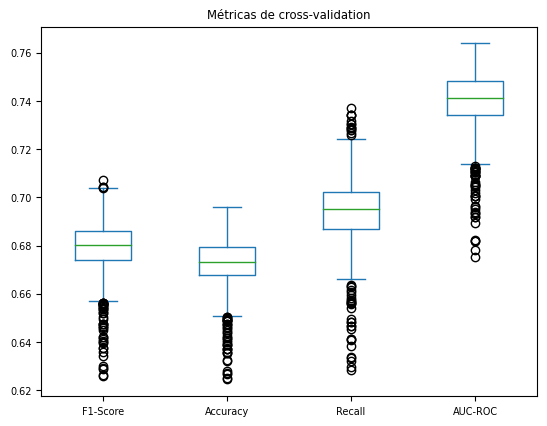

In [205]:
plt.figure(figsize=(4,3));
pd.DataFrame(metrics).plot(kind='box');
plt.title('Métricas de cross-validation');

# 9. Best Model 

In [206]:
results.best_params_

{'num_leaves': 32,
 'n_estimators': 850,
 'min_split_gain': 0.201,
 'max_depth': 32,
 'learning_rate': 0.01,
 'feature_fraction': 0.26,
 'bagging_freq': 1}

In [214]:
results.best_score_

0.7638648713801729

In [207]:
final_model = lgb.LGBMClassifier(**results.best_params_)
final_model.fit(X_train, y_train.values.ravel());
y_pred = final_model.predict(X_test)

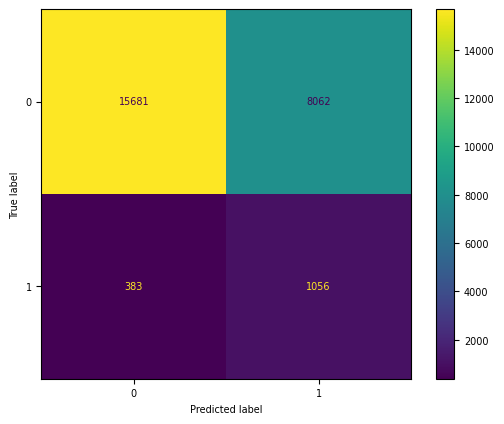

In [208]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [209]:
roc_auc_score(y_test, y_pred)

0.6971451181090585

In [210]:
accuracy_score(y_test, y_pred)

0.6646414105313319

# 10. Conclusions 

- O melhor modelo foi uma versão do LightGBM;
- A melhor métrica de treinamento no cross-validation com k-fold foi ROC-AUC = 0,76
- O melhor modelo teve ROC-AUC = 0,69 no conjunto de testes, que foi entendido aqui como uma boa métrica para o problema, dado o desbalanceamento das classes;
- Podem ser utilizados outras estratégias de reamostragem e também modelos para aprimorar os resultdos;
- O desbalanceamento influenciou em uma grande quantidade de detecções do modelo como fraude incorretamente;
- Sob a perspectiva destas métricas, a precisão das idas a campo para inspeções será consideravelmente assertiva, levando a uma maior recuperação de receita ao mitigar estas fraudes.